# Statistical Inferencing

## Adapted from [`emcee` Quickstart](https://emcee.readthedocs.io/en/stable/tutorials/quickstart/)

The easiest way to get started with using emcee is to use it for a project. To get you started, here’s an annotated, fully-functional example that demonstrates a standard usage pattern.

## How to sample a multi-dimensional Gaussian

We’re going to demonstrate how you might draw samples from the multivariate Gaussian density given by:

$$
p(\vec{x}) \propto \exp \left [ - \frac{1}{2} (\vec{x} -
    \vec{\mu})^\mathrm{T} \, \Sigma ^{-1} \, (\vec{x} - \vec{\mu})
    \right ]
$$

where $\vec{\mu}$ is an $N$-dimensional vector position of the mean of the density and $\Sigma$ is the square N-by-N covariance matrix.

The first thing that we need to do is import the necessary modules:

In [2]:
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

Matplotlib is building the font cache; this may take a moment.


Then, we’ll code up a Python function that returns the density $p(\vec{x})$ for specific values of $\vec{x}$, $\vec{\mu}$ and $\Sigma^{-1}$. In fact, emcee actually requires the logarithm of $p$. We’ll call it `log_prob`:

In [3]:
def log_prob(x, mu, cov):
    diff = x - mu
    return -0.5 * np.dot(diff, np.linalg.solve(cov, diff))

It is important that the first argument of the probability function is
the position of a single "walker" (a *N* dimensional
`numpy` array). The following arguments are going to be constant every
time the function is called and the values come from the `args` parameter
of our :class:`EnsembleSampler` that we'll see soon.

Now, we'll set up the specific values of those "hyperparameters" in 5
dimensions:

In [34]:
ndim = 5

np.random.seed(42)
means = np.random.rand(ndim)
print(np.mean(means))

cov = 0.5 - np.random.rand(ndim ** 2).reshape((ndim, ndim))
cov = np.triu(cov) #upper triangular matrix
cov += cov.T - np.diag(cov.diagonal()) #adding cov to (transpose of cov - diagonal matrix of cov)
cov = np.dot(cov, cov) #just the square of the matrix

0.5623850983416314


and where `cov` is $\Sigma$.

How about we use 32 walkers? Before we go on, we need to guess a starting point for each
of the 32 walkers. This position will be a 5-dimensional vector so the
initial guess should be a 32-by-5 array.
It's not a very good guess but we'll just guess a
random number between 0 and 1 for each component:

In [6]:
nwalkers = 32
p0 = np.random.rand(nwalkers, ndim)

Now that we've gotten past all the bookkeeping stuff, we can move on to
the fun stuff. The main interface provided by `emcee` is the
:class:`EnsembleSampler` object so let's get ourselves one of those:

In [13]:
import emcee

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[means, cov])

Remember how our function `log_prob` required two extra arguments when it
was called? By setting up our sampler with the `args` argument, we're
saying that the probability function should be called as:

In [28]:
log_prob(p0[0], means, cov)

-2.5960945890854434

If we didn't provide any
`args` parameter, the calling sequence would be `log_prob(p0[0])` instead.

It's generally a good idea to run a few "burn-in" steps in your MCMC
chain to let the walkers explore the parameter space a bit and get
settled into the maximum of the density. We'll run a burn-in of 100
steps (yep, I just made that number up... it's hard to really know
how many steps of burn-in you'll need before you start) starting from
our initial guess ``p0``:

In [15]:
state = sampler.run_mcmc(p0, 100)
sampler.reset()

You'll notice that I saved the final position of the walkers (after the
100 steps) to a variable called `state`. You can check out what will be
contained in the other output variables by looking at the documentation for
the :func:`EnsembleSampler.run_mcmc` function. The call to the
:func:`EnsembleSampler.reset` method clears all of the important bookkeeping
parameters in the sampler so that we get a fresh start. It also clears the
current positions of the walkers so it's a good thing that we saved them
first.

Now, we can do our production run of 10000 steps:

In [16]:
sampler.run_mcmc(state, 10000);

The samples can be accessed using the :func:`EnsembleSampler.get_chain` method.
This will return an array
with the shape `(10000, 32, 5)` giving the parameter values for each walker
at each step in the chain.
Take note of that shape and make sure that you know where each of those numbers come from.
You can make histograms of these samples to get an estimate of the density that you were sampling:

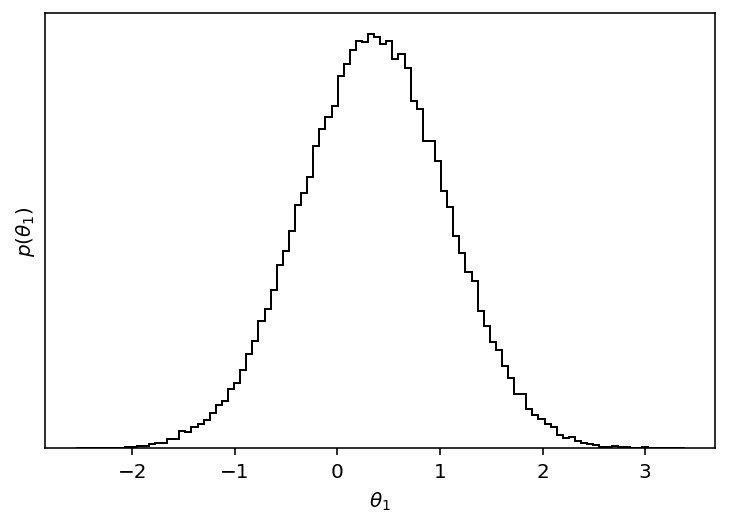

In [17]:
import matplotlib.pyplot as plt

samples = sampler.get_chain(flat=True)
plt.hist(samples[:, 0], 100, color="k", histtype="step")
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([]);

Another good test of whether or not the sampling went well is to check
the mean acceptance fraction of the ensemble using the
:func:`EnsembleSampler.acceptance_fraction` property:

In [18]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.552


and the integrated autocorrelation time (see the :ref:`autocorr` tutorial for more details)

In [19]:
print(
    "Mean autocorrelation time: {0:.3f} steps".format(
        np.mean(sampler.get_autocorr_time())
    )
)

Mean autocorrelation time: 57.112 steps


## Adapted from [`emcee` Fitting a model to data](https://emcee.readthedocs.io/en/stable/tutorials/line/)

If you're reading this right now then you're probably interested in using
emcee to fit a model to some noisy data.
On this page, I'll demonstrate how you might do this in the simplest
non-trivial model that I could think of: fitting a line to data when you
don't believe the error bars on your data.
The interested reader should check out [Hogg, Bovy & Lang (2010)](https://arxiv.org/abs/1008.4686) for a much more complete discussion of how
to fit a line to data in The Real World™ and why MCMC might come in handy.

## The generative probabilistic model

When you approach a new problem, the first step is generally to write down the
*likelihood function* (the probability of a dataset given the model
parameters).
This is equivalent to describing the generative procedure for the data.
In this case, we're going to consider a linear model where the quoted
uncertainties are underestimated by a constant fractional amount.
You can generate a synthetic dataset from this model:

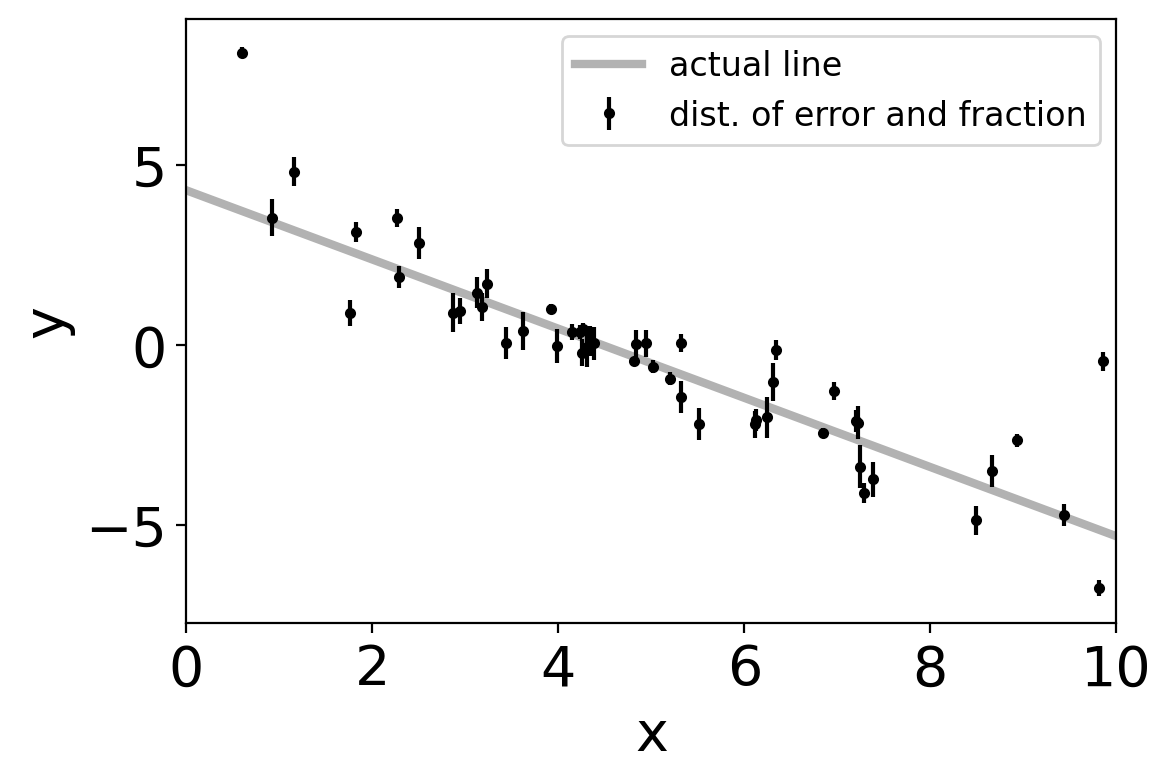

In [47]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(123)
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

# Choose the "true" parameters.
m_true = -0.9594 # slope
b_true = 4.294 # y-intercept
f_true = 0.534 # fractional amount

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N)) # produces array of uniform random numbers between 0-10
yerr = 0.1 + 0.5 * np.random.rand(N) # y error
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N) # add normal distribution of the fractional amount of y
y += yerr * np.random.randn(N) # add normal distribution of the error of y

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0, label='dist. of error') # y is underestimated by fractional error
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label='actual line') # original line
plt.legend(loc=1, prop={'size': 12})
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

The true model is shown as the thick grey line and the effect of the
underestimated uncertainties is obvious when you look at this figure.
The standard way to fit a line to these data (assuming independent Gaussian
error bars) is linear least squares.
Linear least squares is appealing because solving for the parameters—and
their associated uncertainties—is simply a linear algebraic operation.
Following the notation in [Hogg, Bovy & Lang (2010)](https://arxiv.org/abs/1008.4686), the linear least squares solution to these
data is

Least-squares estimates:
m = -1.104 ± 0.016
b = 5.441 ± 0.091


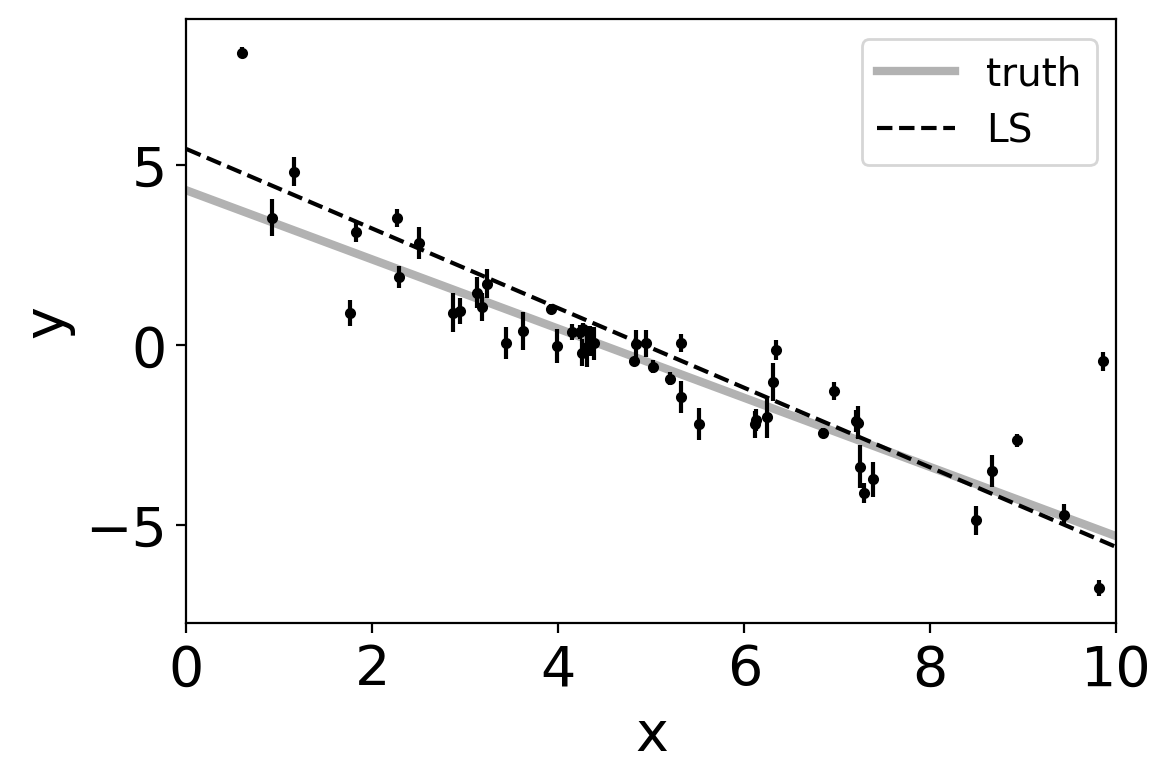

In [49]:
A = np.vander(x, 2) # make vandermonde matrices (shape 50, 2) out of x values
C = np.diag(yerr * yerr) # make diagonal matrix out of square of y-errors
ATA = np.dot(A.T, A / (yerr ** 2)[:, None]) #finds A^T•A and divides by error squared (C) shape(2,2)
cov = np.linalg.inv(ATA) #inverse
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr ** 2)) #this is least-squares solution
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0]))) #error is sqrt of diagonals of covariance matrix
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [101]:
# print(np.dot(A.T, A / (yerr ** 2)[:, None]))
# print(A.shape)
# v = (yerr ** 2)[:, None]
# t = A / v
# print(A.shape)
# print(t.shape)
# print(v)

# q = np.random.rand(50,2)
# d = np.random.rand(50,1)
# print(q[0:5])
# print('\n')
# print(d[0:5])
# print('\n')
# print((q/d)[0:5])

qwr = y / yerr ** 2
print(w.shape)

(2,)


This figure shows the least-squares estimate of the line parameters as a dashed line.
This isn't an unreasonable result but the uncertainties on the slope and
intercept seem a little small (because of the small error bars on most of the
data points).

## Maximum likelihood estimation

The least squares solution found in the previous section is the maximum
likelihood result for a model where the error bars are assumed correct,
Gaussian and independent.
We know, of course, that this isn't the right model.
Unfortunately, there isn't a generalization of least squares that supports a
model like the one that we know to be true.
Instead, we need to write down the likelihood function and numerically
optimize it.
In mathematical notation, the correct likelihood function is:

$$
    \ln\,p(y\,|\,x,\sigma,m,b,f) =
    -\frac{1}{2} \sum_n \left[
        \frac{(y_n-m\,x_n-b)^2}{s_n^2}
        + \ln \left ( 2\pi\,s_n^2 \right )
    \right]
$$

where

$$
    s_n^2 = \sigma_n^2+f^2\,(m\,x_n+b)^2 \quad .
$$

This likelihood function is simply a Gaussian where the variance is
underestimated by some fractional amount:  $f$.
In Python, you would code this up as:

In [59]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

In this code snippet, you'll notice that we're using the logarithm of $f$
instead of $f$ itself for reasons that will become clear in the next section.
For now, it should at least be clear that this isn't a bad idea because it
will force $f$ to be always positive.
A good way of finding this numerical optimum of this likelihood function is to
use the [scipy.optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html) module:

Maximum likelihood estimates:
m = -1.003
b = 4.528
f = 0.454


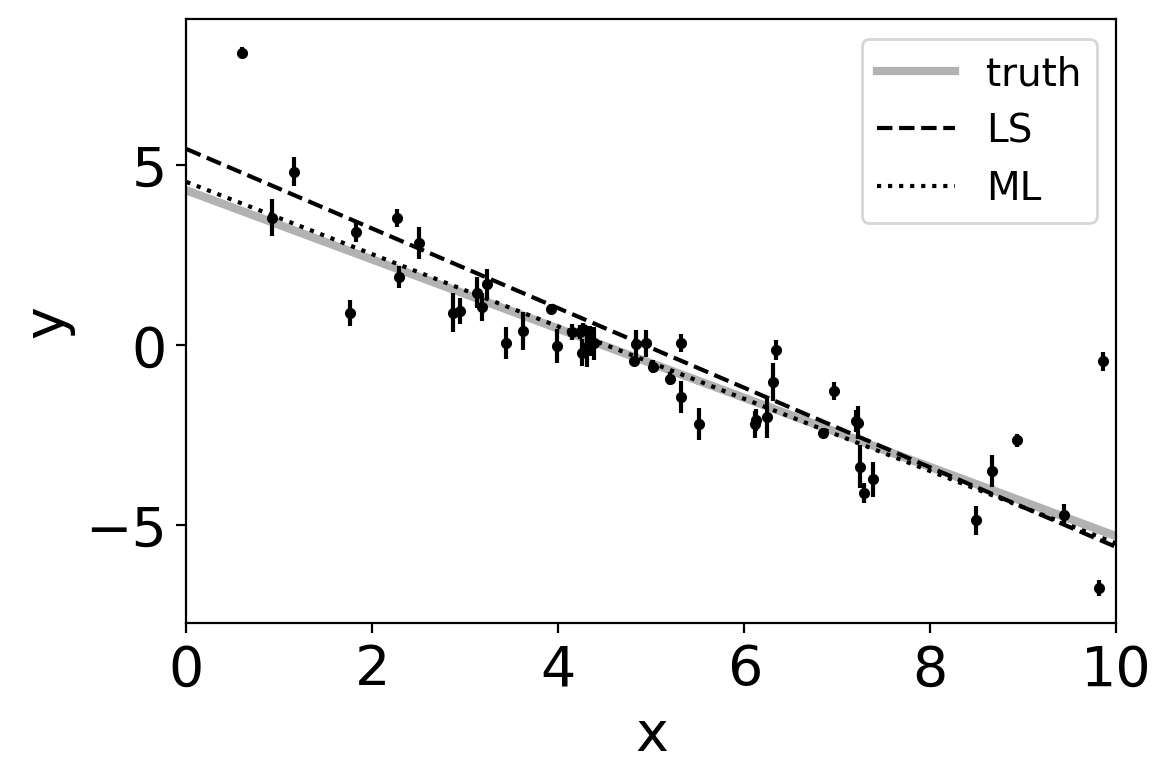

In [60]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

It's worth noting that the optimize module *minimizes* functions whereas we
would like to maximize the likelihood.
This goal is equivalent to minimizing the *negative* likelihood (or in this
case, the negative *log* likelihood).
In this figure, the maximum likelihood (ML) result is plotted as a dotted black line—compared to
the true model (grey line) and linear least-squares (LS; dashed line).
That looks better!

The problem now: how do we estimate the uncertainties on *m* and *b*?
What's more, we probably don't really care too much about the value of *f* but
it seems worthwhile to propagate any uncertainties about its value to our
final estimates of *m* and *b*.
This is where MCMC comes in.

## Marginalization & uncertainty estimation

This isn't the place to get into the details of why you might want to use MCMC
in your research but it is worth commenting that a common reason is that you
would like to marginalize over some "nuisance parameters" and find an estimate
of the posterior probability function (the distribution of parameters that is
consistent with your dataset) for others.
MCMC lets you do both of these things in one fell swoop!
You need to start by writing down the posterior probability function (up to a
constant):

$$
    p (m,b,f\,|\,x,y,\sigma) \propto p(m,b,f)\,p(y\,|\,x,\sigma,m,b,f) \quad .
$$

We have already, in the previous section, written down the likelihood function

$$
p(y\,|\,x,\sigma,m,b,f)
$$

so the missing component is the "prior" function

$$
p(m,b,f) \quad 
$$

This function encodes any previous knowledge that we have about the
parameters: results from other experiments, physically acceptable ranges, etc.
It is necessary that you write down priors if you're going to use MCMC because
all that MCMC does is draw samples from a probability distribution and you
want that to be a probability distribution for your parameters.
This is important: **you cannot draw parameter samples from your likelihood
function**.
This is because a likelihood function is a probability distribution **over
datasets** so, conditioned on model parameters, you can draw representative
datasets (as demonstrated at the beginning of this exercise) but you cannot
draw parameter samples.

In this example, we'll use uniform (so-called "uninformative") priors on $m$,
$b$ and the logarithm of $f$.
For example, we'll use the following conservative prior on $m$:

$$
p(m) = \left \{\begin{array}{ll}
        1 / 5.5 \,, & \mbox{if}\,-5 < m < 1/2 \\
        0 \,, & \mbox{otherwise}
    \end{array}
    \right .
$$

In code, the log-prior is (up to a constant):

In [61]:
def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

Then, combining this with the definition of ``log_likelihood`` from above, the full
log-probability function is:

In [62]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr) # should this be multiplication?

After all this setup, it's easy to sample this distribution using emcee.
We'll start by initializing the walkers in a tiny Gaussian ball around the
maximum likelihood result (I've found that this tends to be a pretty good
initialization in most cases) and then run 5,000 steps of MCMC.

In [63]:
import emcee

pos = soln.x + 1e-4 * np.random.randn(32, 3) #maximum likelihood result + normal distribution of numbers 0 - 1e-6
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:09<00:00, 550.26it/s]


In [71]:
print(soln.x)

[-1.00300852  4.52831431 -0.79044034]


Let's take a look at what the sampler has done.
A good first step is to look at the time series of the parameters in
the chain.
The samples can be accessed using the :func:`EnsembleSampler.get_chain` method.
This will return an array
with the shape `(5000, 32, 3)` giving the parameter values for each walker
at each step in the chain.
The figure below shows the positions of each walker as a function of the
number of steps in the chain:

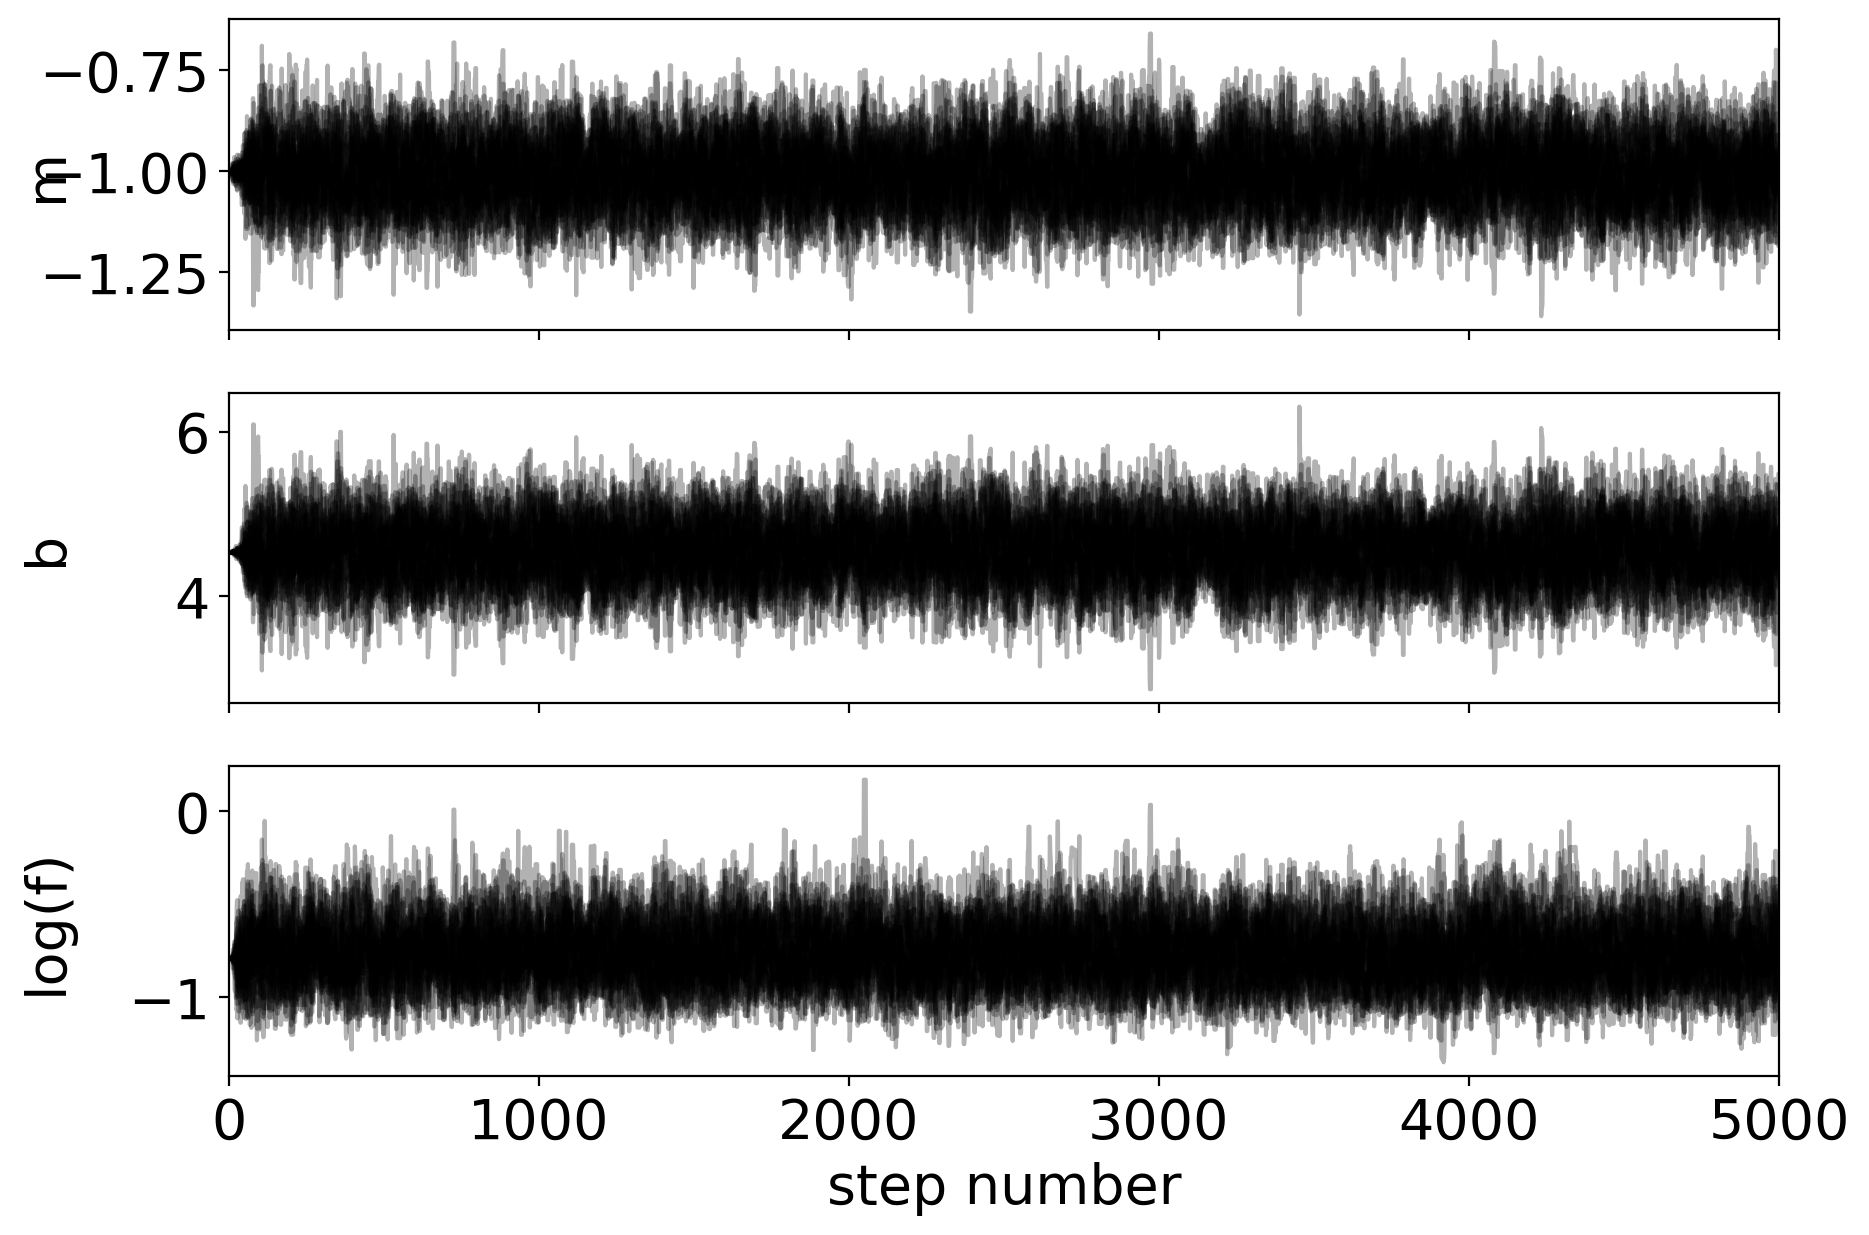

In [64]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

As mentioned above, the walkers start in small distributions around the
maximum likelihood values and then they quickly wander and start exploring the
full posterior distribution.
In fact, after fewer than 50 steps, the samples seem pretty well "burnt-in".
That is a hard statement to make quantitatively, but we can look at an estimate
of the integrated autocorrelation time (see the :ref:`autocorr` tutorial for more details):

In [65]:
tau = sampler.get_autocorr_time()
print(tau)

[39.99526726 39.76501919 41.02623912]


This suggests that only about 40 steps are needed for the chain to "forget" where it started.
It's not unreasonable to throw away a few times this number of steps as "burn-in".
Let's discard the initial 100 steps, thin by about half the autocorrelation time (15 steps), and flatten the chain so that we have a flat list of samples:

In [66]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 3)


## Results

Now that we have this list of samples, let's make one of the most useful plots
you can make with your MCMC results: *a corner plot*.
You'll need the [corner.py module](http://corner.readthedocs.io) but
once you have it, generating a corner plot is as simple as:

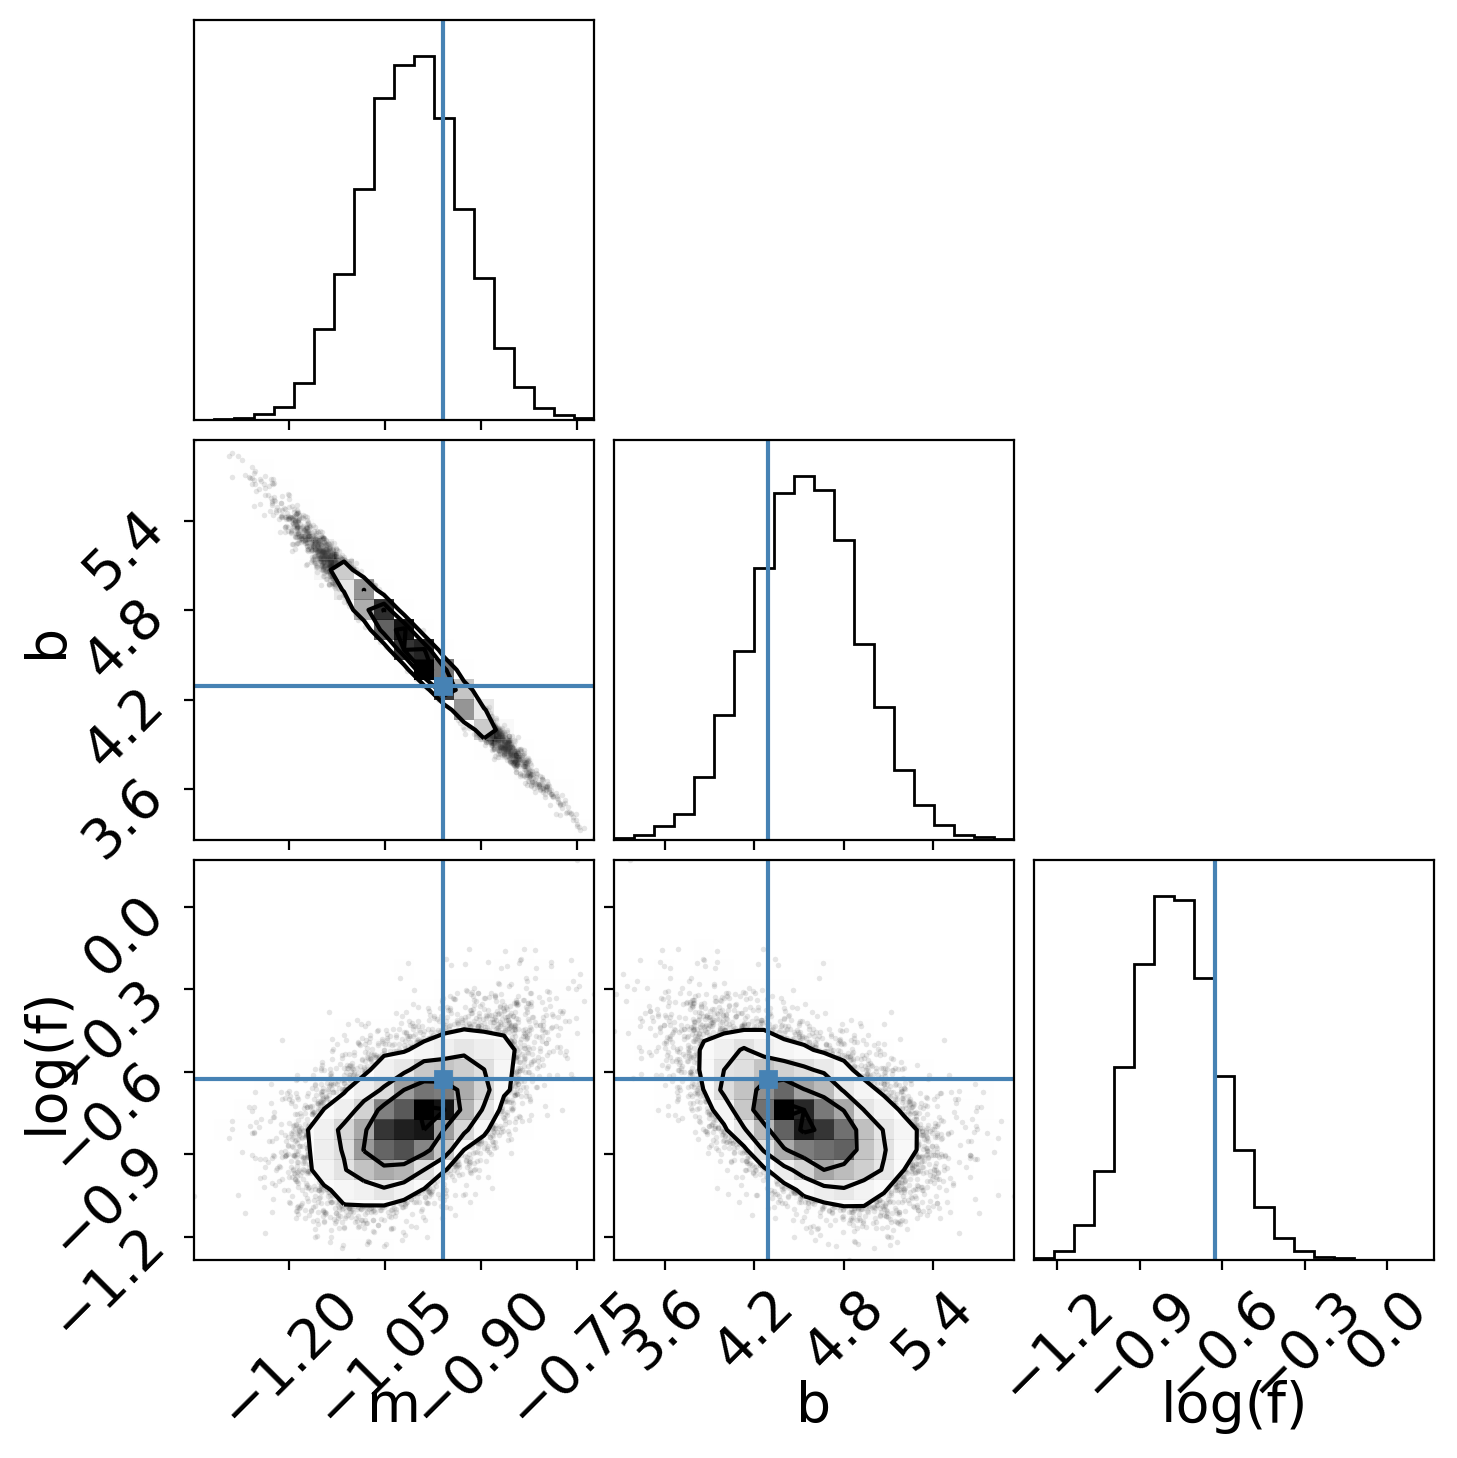

In [72]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
);

The corner plot shows all the one and two dimensional projections of the
posterior probability distributions of your parameters.
This is useful because it quickly demonstrates all of the covariances between
parameters.
Also, the way that you find the marginalized distribution for a parameter or
set of parameters using the results of the MCMC chain is to project the
samples into that plane and then make an N-dimensional histogram.
That means that the corner plot shows the marginalized distribution for each
parameter independently in the histograms along the diagonal and then the
marginalized two dimensional distributions in the other panels.

Another diagnostic plot is the projection of your results into the space of
the observed data.
To do this, you can choose a few (say 100 in this case) samples from the chain
and plot them on top of the data points:

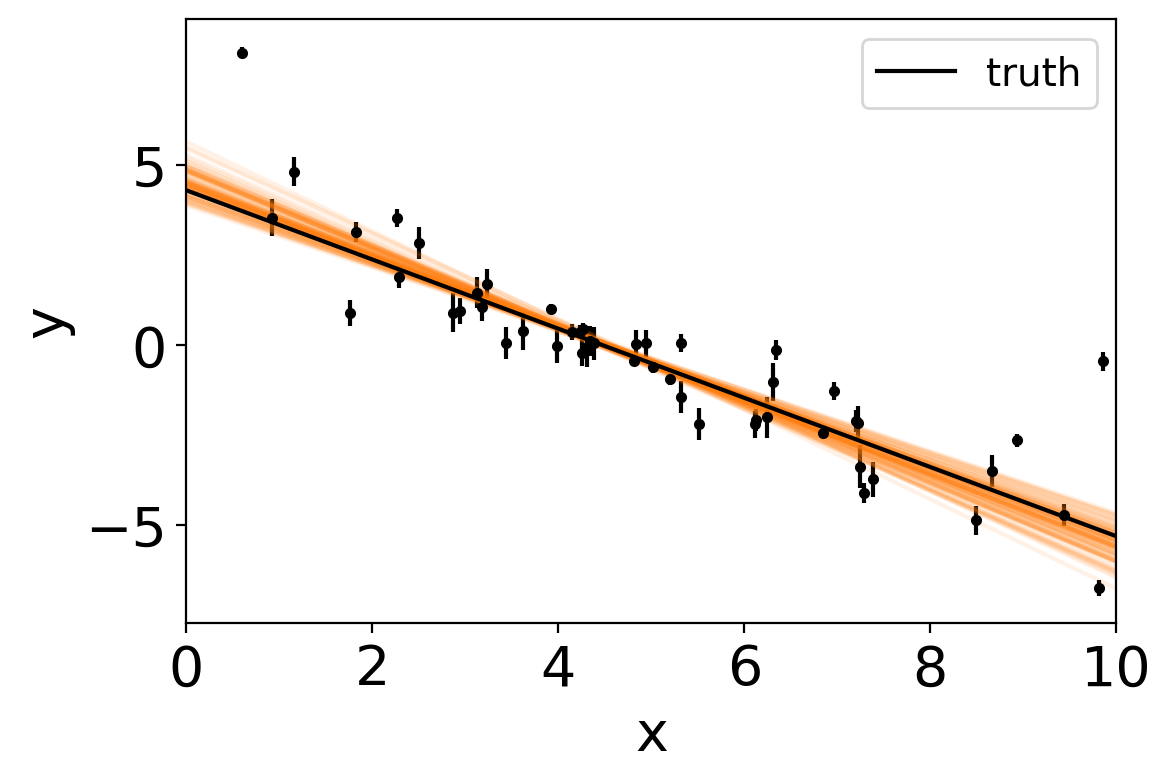

In [73]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

This leaves us with one question: which numbers should go in the abstract?
There are a few different options for this but my favorite is to quote the
uncertainties based on the 16th, 50th, and 84th percentiles of the samples in
the marginalized distributions.
To compute these numbers for this example, you would run:

In [74]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Analyzing fake data w/ `emcee`

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import os
import sys
#import h5py

# emcee backend file
fname = 'simp3_std_medr_medv_noiseless_winterp.h5'

# load the backend
reader = emcee.backends.HDFBackend('../posteriors/'+fname)

# set burn-in
burnin = 2000

# set parameter labels, truths
lbls = ['i', 'PA', 'M', 'r_l', 'z0', 'zpsi', 'Tb0', 'Tbq', 'Tback', 'xi_turb', 'vsys', 'dx', 'dy']
theta = [40., 130., 0.7, 200., 2.3, 1.0, 205., 0.5, 20., 0.05, 0., 0., 0.]

# parse the samples
all_samples = reader.get_chain(discard=0, flat=False) #retrieves chain dataset from file
samples = reader.get_chain(discard=burnin, flat=False) # discards burn-in steps
remove_it = np.where(np.mean(samples[:,:,0], axis=0) < 35.)[0] # locates steps & walkers below 35
all_samples = np.delete(all_samples, remove_it, axis=1) #discards above
samples = np.delete(samples, remove_it, axis=1)
nsteps, nwalk, ndim = samples.shape[0], samples.shape[1],  samples.shape[2] 

In [31]:
f = h5py.File('../posteriors/'+fname, 'r')

list(f.keys())

mc = f['mcmc']

mc.keys()

chain = mc['chain']

print(chain.shape)

(5000, 65, 13)


In [74]:
y = np.random.rand(2, 2, 2)
print(y)

[[[0.90561141 0.89281778]
  [0.7106876  0.28979982]]

 [[0.52141271 0.06514117]
  [0.45187137 0.55638666]]]


In [69]:
print(chain[0:5])
print(np.mean(samples[:,:,0], axis=0))

[[[ 4.41342742e+01  1.33141950e+02  7.16782187e-01 ... -4.60467447e-02
    8.46654938e-02 -3.94096528e-02]
  [ 4.32083847e+01  1.25846574e+02  6.52637096e-01 ... -7.03492603e-02
    4.04237593e-03  7.82667292e-02]
  [ 4.20563532e+01  1.24185625e+02  6.12992372e-01 ...  1.34829077e-02
   -2.56637521e-02  2.46658863e-03]
  ...
  [ 4.71091913e+01  1.31042325e+02  5.81188513e-01 ... -1.91111577e-02
   -4.15808262e-02  3.45984760e-02]
  [ 4.09262165e+01  1.28298126e+02  7.06930985e-01 ... -6.96325765e-02
   -5.02944204e-02  9.98623147e-03]
  [ 3.83271419e+01  1.39251719e+02  7.76261559e-01 ... -4.35661660e-02
    6.43590886e-02  2.28648107e-02]]

 [[ 4.41342742e+01  1.33141950e+02  7.16782187e-01 ... -4.60467447e-02
    8.46654938e-02 -3.94096528e-02]
  [ 4.25498755e+01  1.24630590e+02  6.47590709e-01 ... -6.81383927e-02
   -8.94238164e-03  6.19762238e-02]
  [ 4.20653387e+01  1.24193249e+02  6.12917908e-01 ...  1.34638391e-02
   -2.56574339e-02  2.37266447e-03]
  ...
  [ 4.71091913e+01  1.3

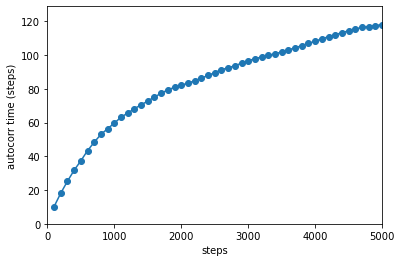

In [15]:
# plot the integrated autocorrelation time convergence every Ntau steps
Ntau = 100
Nmax = all_samples.shape[0]
if (Nmax > Ntau):
    tau_ix = np.empty(np.int(Nmax / Ntau))
    ix = np.empty(np.int(Nmax / Ntau))
    for i in range(len(tau_ix)):
        nn = (i + 1) * Ntau
        ix[i] = nn
        tau = emcee.autocorr.integrated_time(all_samples[:nn,:,:], tol=0)
        tau_ix[i] = np.mean(tau)

    fig = plt.figure()
    plt.plot(ix, tau_ix, '-o')
    plt.xlabel('steps')
    plt.ylabel('autocorr time (steps)')
    plt.xlim([0, Nmax])
    plt.ylim([0, tau_ix.max() + 0.1 * (tau_ix.max() - tau_ix.min())])
    #fig.savefig('../posteriors/mcmc_analysis/'+fname+'.autocorr.png')
    #fig.clf()

<Figure size 360x360 with 0 Axes>

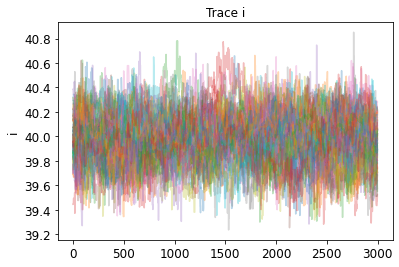

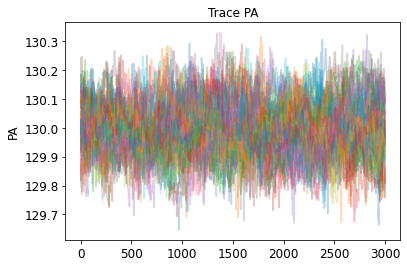

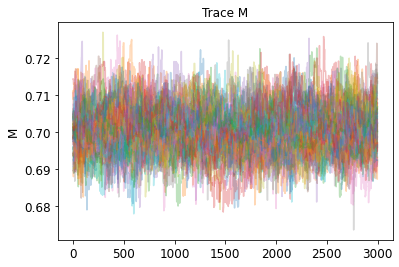

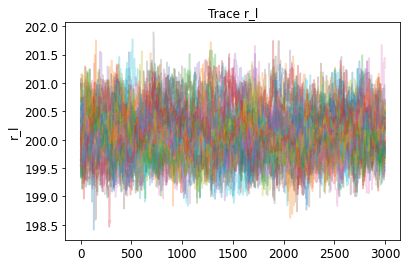

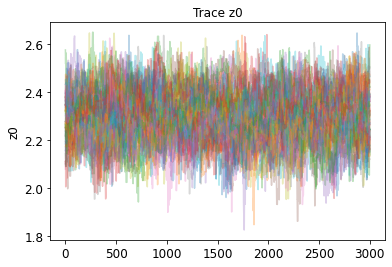

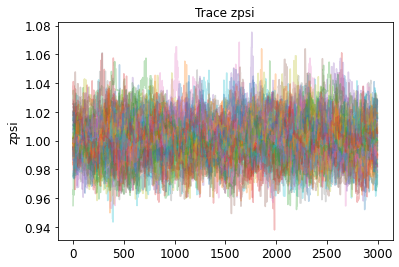

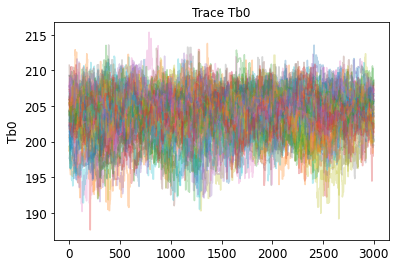

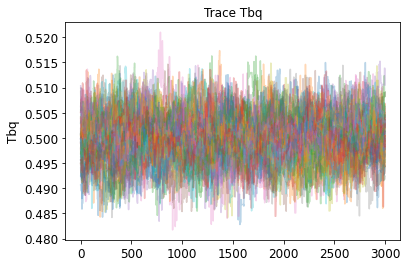

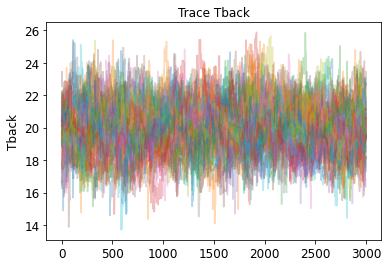

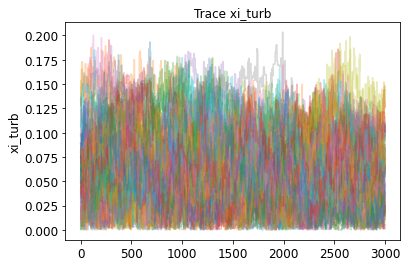

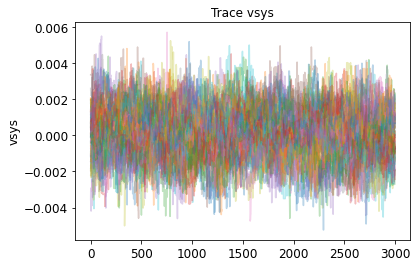

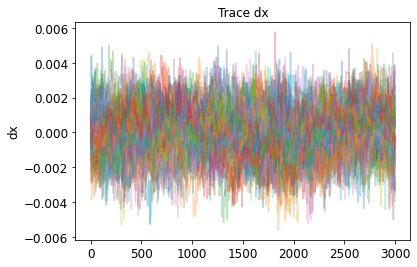

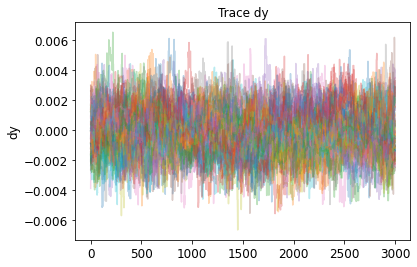

In [50]:
# plot the traces
fig = plt.figure(figsize=(5, 5))
for idim in np.arange(ndim):
    for iw in np.arange(nwalk):
        plt.plot(np.arange(nsteps), samples[:, iw, idim], alpha=0.3)
        plt.ylabel(lbls[idim], fontsize=12)
        plt.title('Trace %s' % lbls[idim])
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
#fig.subplots_adjust(wspace=0.45, hspace=0.3)
#fig.subplots_adjust(left=0.10, right=0.90, bottom=0.04, top=0.99)
#fig.savefig('../posteriors/mcmc_analysis/'+fname+'.traces.png')
#fig.clf()

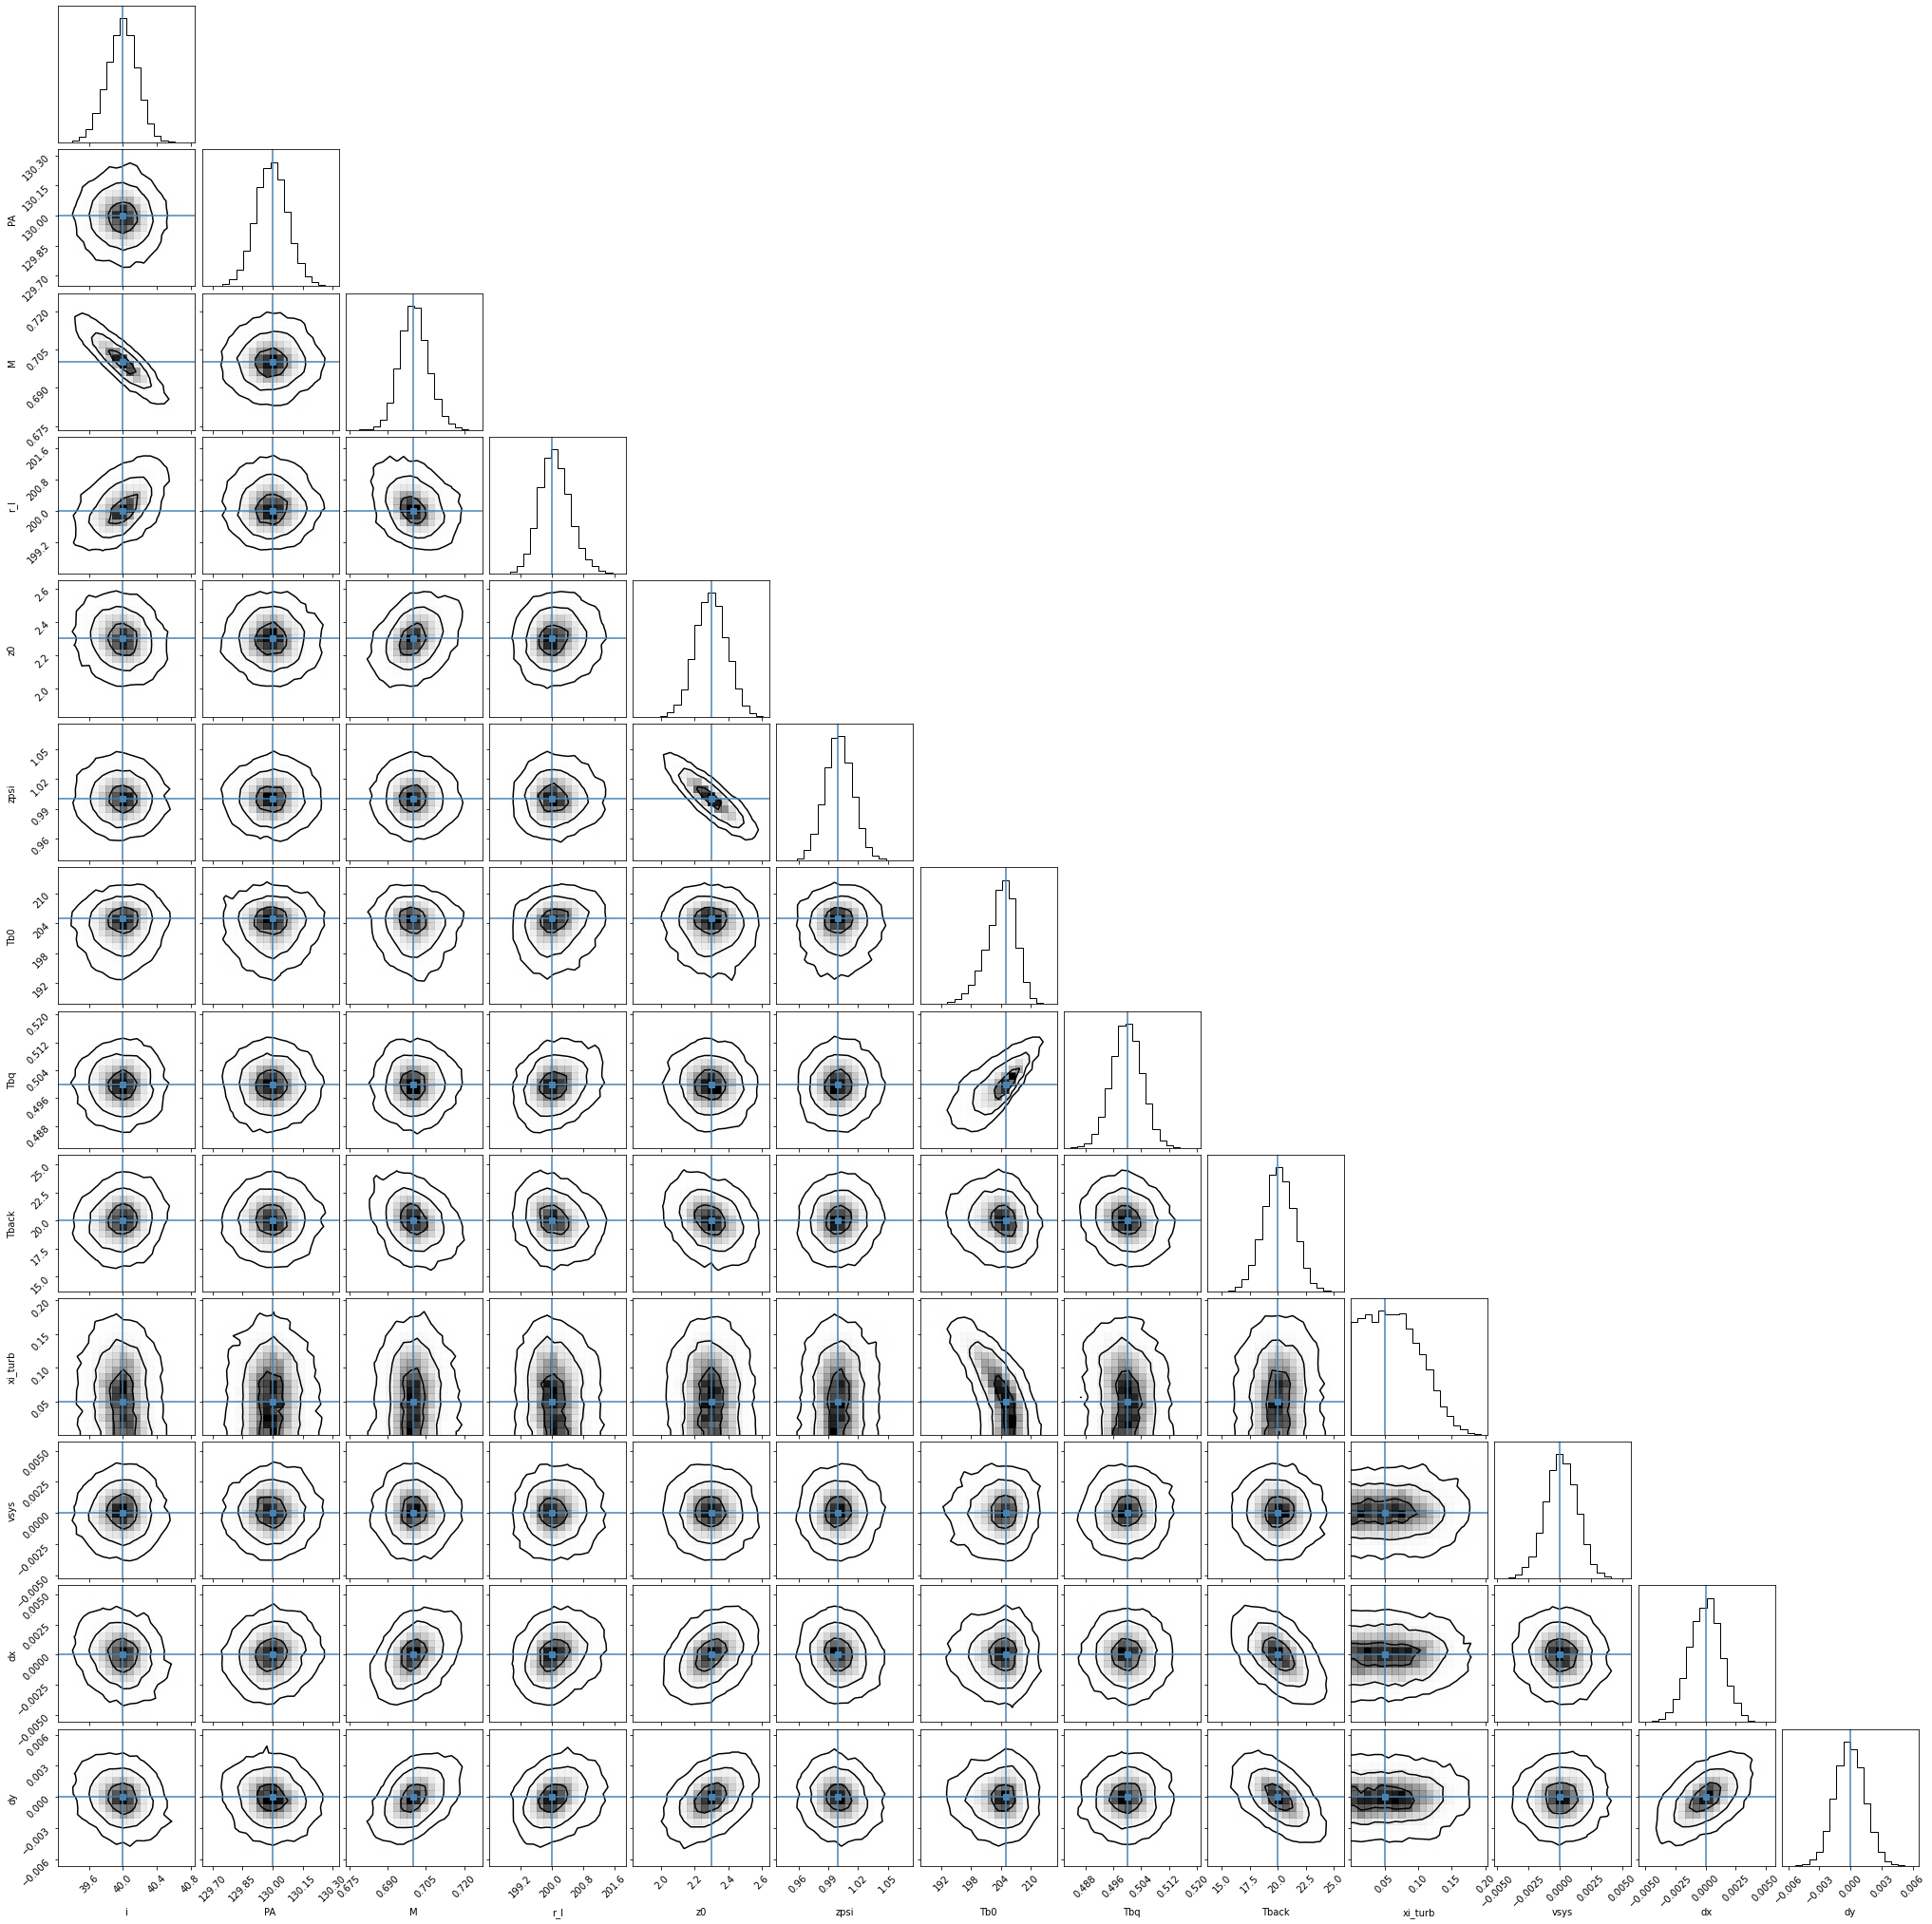

In [17]:
# corner plot to view covariances
levs = 1. - np.exp(-0.5*(np.arange(3)+1)**2)
flat_chain = samples.reshape(-1, ndim)
fig = corner.corner(flat_chain, plot_datapoints=False, levels=levs, 
                    labels=lbls, truths=theta)
#fig.savefig('../posteriors/mcmc_analysis/'+fname+'.corner.png')
#fig.clf()

In [46]:
print('Initial truth values')
for i in range(len(lbls)):
    print('%s = %s' % (lbls[i], theta[i]))

Initial truth values
i = 40.0
PA = 130.0
M = 0.7
r_l = 200.0
z0 = 2.3
zpsi = 1.0
Tb0 = 205.0
Tbq = 0.5
Tback = 20.0
xi_turb = 0.05
vsys = 0.0
dx = 0.0
dy = 0.0


In [54]:
from IPython.display import display, Math
print('MCMC truth values')

for i in range(ndim):
    mcmc = np.percentile(flat_chain[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], lbls[i])
    display(Math(txt))

MCMC truth values


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>